In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.constants import physical_constants
import tinyarray
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Creating an ndarray from ragged")

In [2]:
h_bar = physical_constants['Planck constant over 2 pi'][0]   
m_el = physical_constants['electron mass'][0]         
eV_unit = physical_constants['electron volt'][0]             
el_charge = physical_constants['elementary charge'][0]    
hh = physical_constants['Planck constant'][0]  
mu_B = physical_constants['Bohr magneton'][0]  
mu_B = mu_B/eV_unit

In [3]:
m_ef = 1* m_el
dx = 0.1 * 10**(-9) 
a = 1
mu = 0.01
Delta = 0.25*10**(-3)
t_unit_J = h_bar**(2)/(2*m_ef*dx**2) 
t = t_unit_J/eV_unit 
L = 250
sigma_law = np.matrix([[1, 0], [0, 2]])

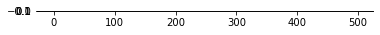

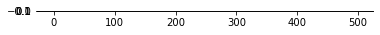

In [4]:
def make_system(P = 0): 
    
    def potential(x):
        return 0#Z*mu*np.exp(-1*(x-L)**2/(2*a*a))
    
    def onsite_NM(site):
        x,= site.pos
        return np.array([[2*t - mu + potential(x) - P*mu, 0], [0, -1*(2*t - mu + potential(x) + P*mu)]])
    
    def onsite_SC(site):
        x,= site.pos
        return np.array([[2*t - mu + potential(x) , Delta], [Delta, -1*(2*t - mu + potential(x) )]])
    
    def onsite(site):
        x,= site.pos
        if (x>=L):
            return np.array([[2*t - mu + potential(x), Delta], [Delta, -1*(2*t - mu + potential(x))]])
        else:
            return np.array([[2*t - mu + potential(x) - P*mu, 0], [0, -1*(2*t - mu + potential(x) + P*mu)]])
            

    def shape(pos):
        x,= pos
        return 0 <= x <= 2*L 

    def shape_lead(pos):
        x,= pos
        return True
    
    def hopping(site1, site2):
        return np.array([[-t, 0], [0, t]])


    sys = kwant.Builder()  
    lat = kwant.lattice.chain(dx*10**9, norbs=2)
    sys[lat.shape(shape,(0,))] = onsite
    sys[lat.neighbors()] = hopping
    

    leadl = kwant.Builder(kwant.TranslationalSymmetry((-dx*10**9,)),conservation_law=sigma_law)
    leadl[lat.shape(shape_lead, (0,))] = onsite_NM
    leadl[lat.neighbors()] = hopping

    leadr = kwant.Builder(kwant.TranslationalSymmetry((dx*10**9,)))
    leadr[lat.shape(shape_lead, (0,))] = onsite_SC
    leadr[lat.neighbors()] = hopping


    sys.attach_lead(leadl)
    sys.attach_lead(leadr)

    sysf = sys.finalized()

    return sysf
sysf = make_system()
kwant.plot(sysf)

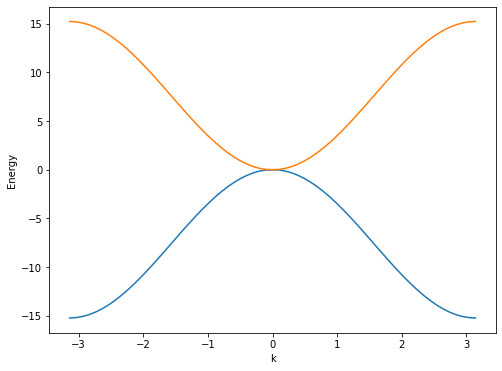

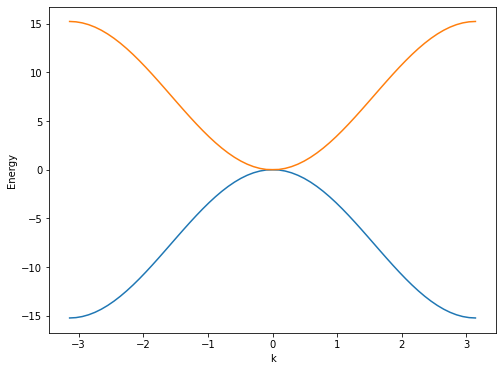

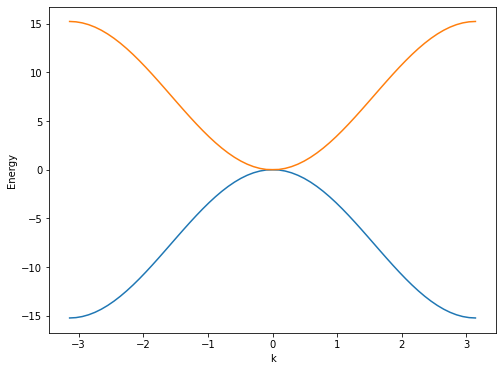

In [5]:
kwant.plotter.bands(sysf.leads[0], show=True, fig_size = (8,6))
kwant.plotter.bands(sysf.leads[1], show=True, fig_size = (8,6))

In [6]:
def andreev_conductance(syst, ene):
    smatrix = kwant.smatrix(syst,ene)
    R_he = smatrix.transmission((0, 1), (0, 0))
    R_ee = smatrix.transmission((0, 0), (0, 0))
    T = smatrix.transmission(1,(0,0))
    return R_he, R_ee, T

def conductance(syst, ene):
    smatrix = kwant.smatrix(syst,ene)
    R_he = smatrix.transmission((0, 1), (0, 0))
    R_ee = smatrix.transmission((0, 0), (0, 0))
    return (1-R_ee+R_he)


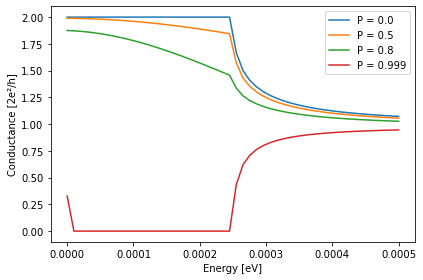

In [89]:
Ne = 50
Emin = 0
Emax = 0.5e-3
P_table = np.array([0, 0.5, 0.8, 0.999])

energies = np.linspace(Emin, Emax, Ne)

for P in P_table:
    system = make_system(P)
    results = [conductance(system, E) for E in energies]
    plt.plot(energies, results, label=f"P = {P}")

plt.xlabel("Energy [eV]")
plt.ylabel("Conductance [2e²/h]")
plt.legend()
plt.tight_layout()
plt.savefig("Rys3.png")
plt.show()

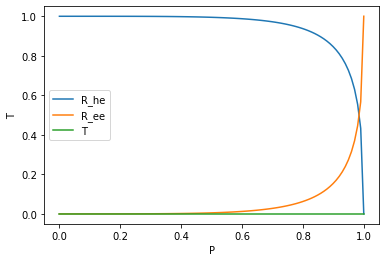

In [9]:
Ne = 50
ene = 1 * 10**(-6)
P_table = np.linspace(0, 0.999999, 100)
T_table = []
R_he_table = []
R_ee_table = []
for P in P_table:
    system = make_system(P=P)
    smatrix = kwant.smatrix(system,ene)
    R_he_table.append(smatrix.transmission((0, 1), (0, 0)))
    R_ee_table.append(smatrix.transmission((0, 0), (0, 0)))
    T_table.append(smatrix.transmission(1,(0,0)))
plt.plot(P_table, R_he_table, label = "R_he")
plt.plot(P_table, R_ee_table, label = "R_ee")
plt.plot(P_table, T_table, label = "T")
plt.legend()
plt.xlabel("P")
plt.ylabel("T")
plt.savefig("Rys4.png")
plt.show()

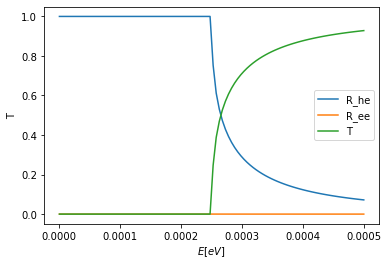

In [54]:
# Ne = 100
# Emin = 0
# Emax = 0.5e-3

# results = [andreev_conductance(sysf, i) for i in np.linspace(Emin, Emax, Ne)]
# res1, res2, res3 = zip(*results)  # Rozpakowanie do osobnych list
# plt.plot(np.linspace(Emin, Emax, Ne), res1, label = "R_he")
# plt.plot(np.linspace(Emin, Emax, Ne), res2, label = "R_ee")
# plt.plot(np.linspace(Emin, Emax, Ne), res3, label = "T")
# plt.xlabel(r"$E [eV]$")
# plt.ylabel("T")
# plt.legend()
# plt.savefig("Rys1.png")

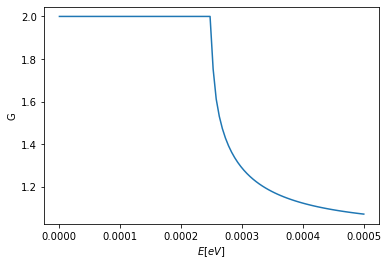

In [52]:
# Ne = 100
# Emin = 0
# Emax = 0.5e-3

# results= [conductance(sysf, i) for i in np.linspace(Emin, Emax, Ne)]
# plt.plot(np.linspace(Emin, Emax, Ne), results)
# plt.xlabel(r"$E [eV]$")
# plt.ylabel("G")
# plt.savefig("Rys2.png")

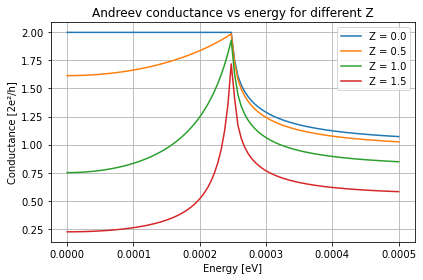

In [38]:
# Ne = 100
# Emin = 0
# Emax = 0.5e-3
# Z_table = np.array([0, 0.5, 1.0, 1.5])

# energies = np.linspace(Emin, Emax, Ne)

# for Z in Z_table:
#     system = make_system(Z = Z)
#     results = [conductance(system, E) for E in energies]
#     plt.plot(energies, results, label=f"Z = {Z}")

# plt.xlabel("Energy [eV]")
# plt.ylabel("Conductance [2e²/h]")
# plt.title("Andreev conductance vs energy for different Z")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("Z.png")
# plt.show()


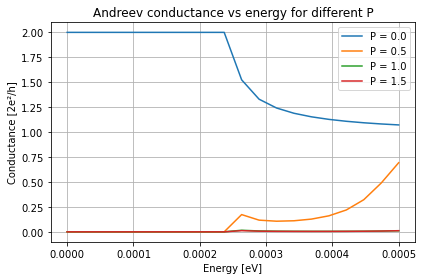

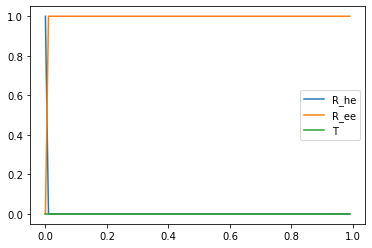